In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
path = "C:/Users/MrJoker\Desktop/Clinical Data generation/data"

In [2]:
# Function for cleanly displaying quick dataframe information
def show_df(df):
    print(f"{df.shape[0]:,} rows x {df.shape[1]} columns")
    return df.head()

In [4]:
lab_events = pd.read_csv(f"{path}/labevents.csv")
lab_items = pd.read_csv(f"{path}/d_labitems.csv")
patients_df = pd.read_csv(f"{path}/patients.csv")
show_df(lab_events)

107,727 rows x 16 columns


,labevent_id,subject_id,hadm_id,specimen_id,itemid,order_provider_id,charttime,storetime,value,valuenum,valueuom,ref_range_lower,ref_range_upper,flag,priority,comments
0,172061,10014354,29600294.0,1808066,51277,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,15.4,15.40,%,10.5,15.5,NaN,ROUTINE,NaN
1,172062,10014354,29600294.0,1808066,51279,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,3.35,3.35,m/uL,4.6,6.1,abnormal,ROUTINE,NaN
2,172068,10014354,29600294.0,1808066,52172,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,49.7,49.70,fL,35.1,46.3,abnormal,ROUTINE,NaN
3,172063,10014354,29600294.0,1808066,51301,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,20.3,20.30,K/uL,4.0,10.0,abnormal,ROUTINE,NaN
4,172050,10014354,29600294.0,1808066,51249,NaN,2148-08-16 00:00:00,2148-08-16 01:30:00,31.1,31.10,g/dL,32.0,37.0,abnormal,ROUTINE,NaN


In [ ]:
# Firstly, Cleaning Lab Events, checking for NaNs and Dropping them with unwanted Columns
def clean_lab_events(events_df):
    lab_events = events_df.drop(['order_provider_id','charttime','storetime','flag','priority','comments'],axis=1)
    lab_events = lab_events.dropna()
    return lab_events
lab_events = clean_lab_events(lab_events)
show_df(lab_events)

65,406 rows x 10 columns


,labevent_id,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper
0,172061,10014354,29600294.0,1808066,51277,15.4,15.40,%,10.5,15.5
1,172062,10014354,29600294.0,1808066,51279,3.35,3.35,m/uL,4.6,6.1
2,172068,10014354,29600294.0,1808066,52172,49.7,49.70,fL,35.1,46.3
3,172063,10014354,29600294.0,1808066,51301,20.3,20.30,K/uL,4.0,10.0
4,172050,10014354,29600294.0,1808066,51249,31.1,31.10,g/dL,32.0,37.0


In [ ]:
# Again Cleaning unwanted labels as they have 'Delete' values which prevent from filtering most frequent labels.
# Next filtering only the blood fluid, Urine and other samples are dropped.
def clean_lab_items(items_df):
    lab_items = items_df.dropna()
    delete_mask = lab_items["label"] == "Delete"
    lab_items = lab_items[~delete_mask]
    lab_items = lab_items[lab_items['fluid'] == "Blood"]

    return lab_items
lab_items = clean_lab_items(lab_items)
show_df(lab_items)

800 rows x 4 columns


,itemid,label,fluid,category
0,50808,Free Calcium,Blood,Blood Gas
1,50826,Tidal Volume,Blood,Blood Gas
2,50813,Lactate,Blood,Blood Gas
3,52029,% Ionized Calcium,Blood,Blood Gas
4,50801,Alveolar-arterial Gradient,Blood,Blood Gas


In [ ]:
# Extracting Common biomarkers present in lab events and lab items dataframes, using itemid which is the unique id across the dataset.

#blood_biomarkers_present
available_itemid = set(lab_events['itemid'].unique())
lab_items = lab_items[lab_items['itemid'].isin(available_itemid)]

# Creating a groupby of top 20 most common labels.
top_10_blood_biomarkers = lab_items.groupby('label')['itemid'].first().loc[lab_items['label'].value_counts().head(20).index].reset_index()

In [8]:
# Filtering this groupby into the lab events to create a filtered lab_events and merging the label and itemid columns
def filtered_events(events_df,top_biomarkers):
    filtered_lab_events = events_df[events_df['itemid'].isin(top_biomarkers['itemid'])]
    filtered_lab_events = filtered_lab_events.merge(top_biomarkers[['itemid','label']], on='itemid', how='left')
    return filtered_lab_events
filtered_lab_events = filtered_events(events_df=lab_events, top_biomarkers=top_10_blood_biomarkers)
show_df(filtered_lab_events)

3,827 rows x 11 columns


,labevent_id,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,label
0,172062,10014354,29600294.0,1808066,51279,3.35,3.35,m/uL,4.6,6.1,Red Blood Cells
1,172054,10014354,29600294.0,1808066,51254,2,2.00,%,5.0,13.0,Monocytes
2,172567,10014354,26486158.0,46932894,51254,3,3.00,%,5.0,13.0,Monocytes
3,172575,10014354,26486158.0,46932894,51279,2.99,2.99,m/uL,4.6,6.1,Red Blood Cells
4,408903,10035631,29462354.0,14644463,51254,5,5.00,%,2.0,11.0,Monocytes


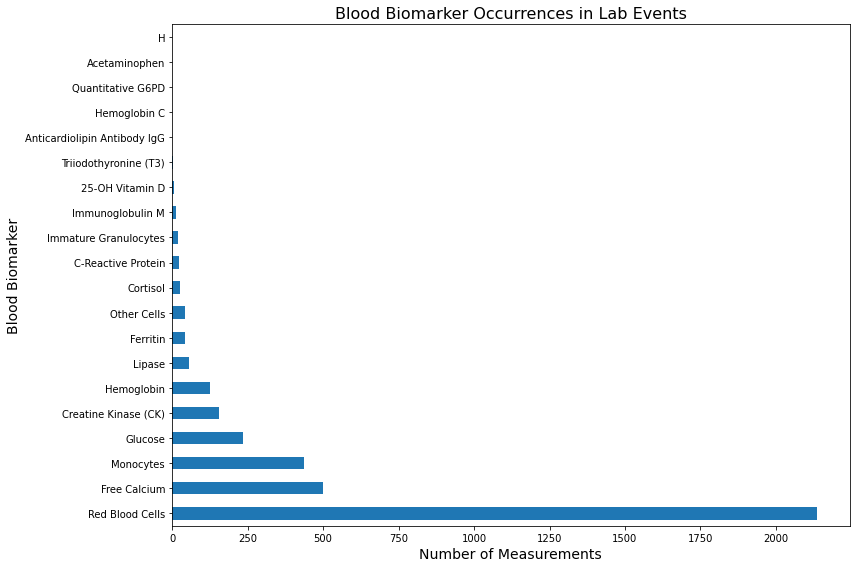

In [9]:
def display_most_common_labels(filtered_labels):
    biomarkers_count = filtered_labels['label'].value_counts()
    plt.figure(figsize=(12,8))
    biomarkers_count.plot(kind='barh')
    plt.title('Blood Biomarker Occurrences in Lab Events', fontsize=16)
    plt.xlabel('Number of Measurements', fontsize=14)
    plt.ylabel('Blood Biomarker', fontsize=14)
    plt.tight_layout()
    plt.show()

display_most_common_labels(filtered_lab_events)

In [ ]:
# Have merged patients demographics with the biomarkers data
filtered_lab_events = filtered_lab_events.merge(patients_df[['subject_id','gender','anchor_age']], on='subject_id', how='left')
show_df(filtered_lab_events)

3,827 rows x 13 columns


,labevent_id,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,label,gender,anchor_age
0,172062,10014354,29600294.0,1808066,51279,3.35,3.35,m/uL,4.6,6.1,Red Blood Cells,M,60
1,172054,10014354,29600294.0,1808066,51254,2,2.00,%,5.0,13.0,Monocytes,M,60
2,172567,10014354,26486158.0,46932894,51254,3,3.00,%,5.0,13.0,Monocytes,M,60
3,172575,10014354,26486158.0,46932894,51279,2.99,2.99,m/uL,4.6,6.1,Red Blood Cells,M,60
4,408903,10035631,29462354.0,14644463,51254,5,5.00,%,2.0,11.0,Monocytes,M,63


In [11]:
# Finally, Keeping only the top 10 blood biomarkers data 
final_lab_data = filtered_lab_events[filtered_lab_events['label'].isin(filtered_lab_events['label'].value_counts().head(10).index)]
show_df(final_lab_data)

3,757 rows x 13 columns


,labevent_id,subject_id,hadm_id,specimen_id,itemid,value,valuenum,valueuom,ref_range_lower,ref_range_upper,label,gender,anchor_age
0,172062,10014354,29600294.0,1808066,51279,3.35,3.35,m/uL,4.6,6.1,Red Blood Cells,M,60
1,172054,10014354,29600294.0,1808066,51254,2,2.00,%,5.0,13.0,Monocytes,M,60
2,172567,10014354,26486158.0,46932894,51254,3,3.00,%,5.0,13.0,Monocytes,M,60
3,172575,10014354,26486158.0,46932894,51279,2.99,2.99,m/uL,4.6,6.1,Red Blood Cells,M,60
4,408903,10035631,29462354.0,14644463,51254,5,5.00,%,2.0,11.0,Monocytes,M,63


In [12]:
# Creating a overview for biomarker ranges which can be used for data generation

biomarker_ranges = final_lab_data.groupby('label').agg({
    'valuenum': ['min', 'max', 'mean', 'count'],
    'ref_range_lower': 'first',
    'ref_range_upper': 'first',
    'valueuom': 'first'
}).round(2)
biomarker_ranges.head(10)

valuenum                          ref_range_lower  \
                          min       max     mean count           first   
label                                                                    
Cortisol                 3.00     45.40    19.84    25            2.00   
Creatine Kinase (CK)     7.00  16865.00  1703.72   154           47.00   
Ferritin                 8.30  33546.00  1689.94    44           13.00   
Free Calcium             0.70      1.42     1.11   499            1.12   
Glucose                 67.00    461.00   140.68   234           70.00   
Hemoglobin               5.00     16.00    10.29   127           14.00   
Lipase                  12.00    363.00    81.70    57            0.00   
Monocytes                0.00     69.00     7.56   438            5.00   
Other Cells              0.00      8.00     3.00    42            0.00   
Red Blood Cells          1.12      6.72     3.31  2137            4.60   

                     ref_range_upper valueuom  
                               first    first  
label                                          
Cortisol                       20.00    ug/dL  
Creatine Kinase (CK)          322.00     IU/L  
Ferritin                      150.00    ng/mL  
Free Calcium                    1.32   mmol/L  
Glucose                       105.00    mg/dL  
Hemoglobin                     18.00     g/dL  
Lipase                         60.00     IU/L  
Monocytes                      13.00        %  
Other Cells                     0.00        %  
Red Blood Cells                 6.10     m/uL

In [13]:
# Dropping the Other Cells label as it has no meaning full reference ranges and overall confusing
final_lab_data = final_lab_data[(final_lab_data['label'] != "Other Cells")]

In [14]:
biomarkers_states = final_lab_data.groupby('label')['valuenum'].agg(['min', 'max', 'mean', 'std'])
biomarkers_states.head(10)

,min,max,mean,std
label,,,,
Cortisol,3.00,45.40,19.836000,12.311745
Creatine Kinase (CK),7.00,16865.00,1703.720779,4004.015448
Ferritin,8.30,33546.00,1689.938636,4987.235301
Free Calcium,0.70,1.42,1.113808,0.097760
Glucose,67.00,461.00,140.679487,52.582939
Hemoglobin,5.00,16.00,10.287402,2.381842
Lipase,12.00,363.00,81.701754,81.363155
Monocytes,0.00,69.00,7.556393,8.831587
Red Blood Cells,1.12,6.72,3.308147,0.733647


In [15]:
# Getting the probabilities of genders and generating a new one based on that.
def gender_generator():
    
    gender_probs = final_lab_data['gender'].value_counts(normalize=True).to_list()
    gen = np.random.choice(['M','F'], p=gender_probs)
    
    if gen == 'F':
        return 'F'
    else:
        return 'M'

# Similarly getting the overall spread for ages and generating appropriate age based on them.
def age_generator():
    
    age_states = final_lab_data['anchor_age'].agg(['min', 'max', 'mean', 'std']).to_dict()
    age_range = np.random.normal(loc=age_states['mean'],scale=age_states['std'],size=1)
    age = np.clip(age_range,a_min=age_states['min'], a_max=age_states['max']).round(2)
    return age[-1]

# Finally, using the stats of biomarkers, and a normal distribution, generating appropriate data for each record. Upper and Lower bounds are set to min and max values.
# Thus making them realistic data for clinical emergency patients.

def generate_synthetic_data(samples=10):

    synthetic_data = []
    for i in range(samples):
        record = {}

        # Gender and Age
        record['Gender'] = gender_generator()
        record['Age'] = age_generator()

        #Blood Biomarkers

        # CORTISOL: normal range = 2-20, ICU up to 45
        record['Cortisol'] = np.clip(np.random.normal(10, 5), 2, 45).round(2)

        # Creatine Kinase: Lognormal, clip at 500
        record['Creatine Kinase (CK)'] = np.clip(np.random.lognormal(np.log(200), 1), 20, 8000).round(2)

        # Ferritin: Lognormal, clip at 2500
        record['Ferritin'] = np.clip(np.random.lognormal(np.log(150), 1), 10, 5000).round(2)

        # Free Calcium: normal, clip 0.7 - 1.4
        record['Free Calcium'] = np.clip(np.random.normal(1.2, 0.1), 0.7, 1.4).round(2)

        # Glucose: Normal, clip 50 - 400
        record['Glucose'] = np.clip(np.random.normal(100, 30), 50 , 400).round(2)

        # Hemoglobin: normal, clip 5 - 18
        record['Hemoglobin'] = np.clip(np.random.normal(12, 3), 5, 18).round(2)

        # Lipase: lognormal, clip at 400
        record['Lipase'] = np.clip(np.random.lognormal(np.log(27), 1), 0, 400).round(2)

        # Monocytes: normal, clip 0 - 40%
        record['Monocytes'] = np.clip(np.random.normal(8, 4), 0, 40).round(2)

        # Red Blood Cells: normal, clip 2 - 6.5
        record['Red Blood Cells'] = np.clip(np.random.normal(5, 0.5), 2, 6.5).round(2)

        
            
        synthetic_data.append(record)
    return pd.DataFrame(synthetic_data)

In [16]:
biomarker_ranges.head(10)

valuenum                          ref_range_lower  \
                          min       max     mean count           first   
label                                                                    
Cortisol                 3.00     45.40    19.84    25            2.00   
Creatine Kinase (CK)     7.00  16865.00  1703.72   154           47.00   
Ferritin                 8.30  33546.00  1689.94    44           13.00   
Free Calcium             0.70      1.42     1.11   499            1.12   
Glucose                 67.00    461.00   140.68   234           70.00   
Hemoglobin               5.00     16.00    10.29   127           14.00   
Lipase                  12.00    363.00    81.70    57            0.00   
Monocytes                0.00     69.00     7.56   438            5.00   
Other Cells              0.00      8.00     3.00    42            0.00   
Red Blood Cells          1.12      6.72     3.31  2137            4.60   

                     ref_range_upper valueuom  
                               first    first  
label                                          
Cortisol                       20.00    ug/dL  
Creatine Kinase (CK)          322.00     IU/L  
Ferritin                      150.00    ng/mL  
Free Calcium                    1.32   mmol/L  
Glucose                       105.00    mg/dL  
Hemoglobin                     18.00     g/dL  
Lipase                         60.00     IU/L  
Monocytes                      13.00        %  
Other Cells                     0.00        %  
Red Blood Cells                 6.10     m/uL

In [17]:
df = generate_synthetic_data(samples=5000)
print(df.describe().T[['min', 'max', 'mean']])

                        min      max        mean
Age                   21.00    91.00   60.732308
Cortisol               2.00    28.08    9.978096
Creatine Kinase (CK)  20.00  7590.69  324.767116
Ferritin              10.00  3642.36  239.720760
Free Calcium           0.85     1.40    1.196686
Glucose               50.00   198.98  100.919200
Hemoglobin             5.00    18.00   11.915046
Lipase                 0.63   400.00   43.600038
Monocytes              0.00    21.39    8.003792
Red Blood Cells        3.15     6.50    5.010670


In [18]:
df.head(10)

,Gender,Age,Cortisol,Creatine Kinase (CK),Ferritin,Free Calcium,Glucose,Hemoglobin,Lipase,Monocytes,Red Blood Cells
0,M,61.35,10.28,341.86,118.35,1.25,90.64,15.53,23.13,11.45,5.33
1,F,38.96,2.00,300.33,226.30,1.00,78.12,13.16,30.51,11.72,4.83
2,M,65.40,7.77,1629.04,196.09,1.24,125.74,13.69,0.63,10.79,4.39
3,M,53.31,7.12,144.22,50.94,1.11,66.18,11.83,8.06,13.26,4.76
4,M,67.45,6.67,60.34,233.57,1.30,76.54,9.49,59.33,0.39,5.50
5,M,86.66,15.28,472.82,145.35,1.14,65.55,13.34,6.17,6.44,5.86
6,F,50.74,7.84,74.18,18.72,1.21,68.58,14.72,8.71,4.22,4.92
7,F,57.88,12.73,164.61,107.83,1.23,89.55,13.84,18.96,10.56,4.73
8,F,91.00,13.08,116.00,175.41,1.30,71.42,5.88,35.92,8.79,5.33
9,M,53.27,12.59,107.89,60.44,1.06,79.56,11.35,18.49,2.96,5.84


In [19]:
def add_missing_values(data_df, biomarker_colums, missing_rate=0.2):
    data_with_missing = data_df.copy()

    for column in biomarker_colums:
        for row in range(len(data_with_missing)):
            if np.random.rand() < missing_rate:
                data_with_missing.loc[row,column] = np.nan
    return data_with_missing
df_data_missing = add_missing_values(df, df.columns[2:].tolist())
df_data_missing

,Gender,Age,Cortisol,Creatine Kinase (CK),Ferritin,Free Calcium,Glucose,Hemoglobin,Lipase,Monocytes,Red Blood Cells
0,M,61.35,10.28,341.86,118.35,1.25,90.64,15.53,23.13,NaN,5.33
1,F,38.96,2.00,300.33,226.30,1.00,78.12,13.16,30.51,11.72,4.83
2,M,65.40,NaN,1629.04,NaN,1.24,125.74,NaN,0.63,10.79,4.39
3,M,53.31,NaN,NaN,NaN,1.11,66.18,11.83,8.06,NaN,NaN
4,M,67.45,NaN,60.34,NaN,1.30,76.54,9.49,NaN,0.39,5.50
...,...,...,...,...,...,...,...,...,...,...,...
4995,M,52.05,4.09,387.40,45.63,1.24,56.06,8.14,18.00,12.06,5.06
4996,F,76.12,10.56,233.42,35.07,1.16,114.02,12.03,4.55,4.66,4.81
4997,F,71.41,9.15,293.48,422.48,1.05,164.86,11.76,89.16,5.73,4.09
4998,M,49.86,NaN,257.80,NaN,1.08,NaN,12.09,3.77,10.04,5.04


In [20]:
df.to_csv(f"{path}/synthetic_biomarkers.csv")
df_data_missing.to_csv(f"{path}/synthetic_missing_biomarkers.csv")

In [69]:
df_data_missing.isna().sum()

Gender                     0
Age                        0
Cortisol                 975
Creatine Kinase (CK)    1019
Ferritin                1016
Free Calcium             999
Glucose                 1002
Hemoglobin              1032
Lipase                  1055
Monocytes                997
Red Blood Cells         1018
dtype: int64

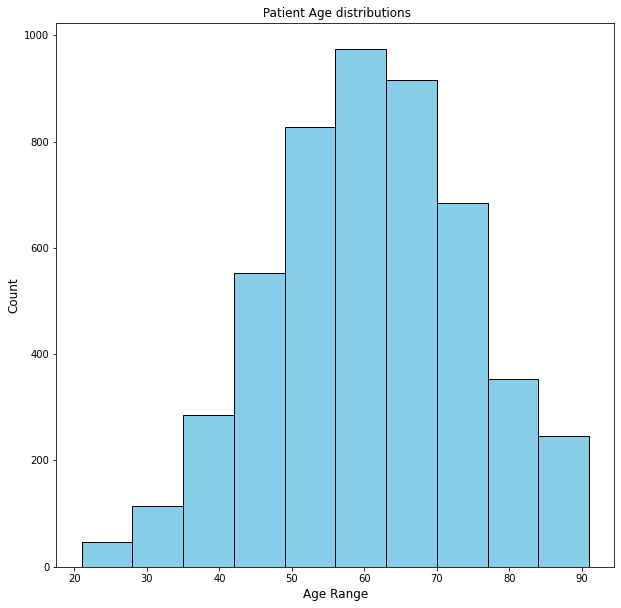

In [37]:
plt.figure(figsize=(10,10))
plt.hist(df['Age'],linewidth=1, edgecolor="black", color='skyblue')
plt.title(" Patient Age distributions", fontsize=12)
plt.xlabel("Age Range", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.show()

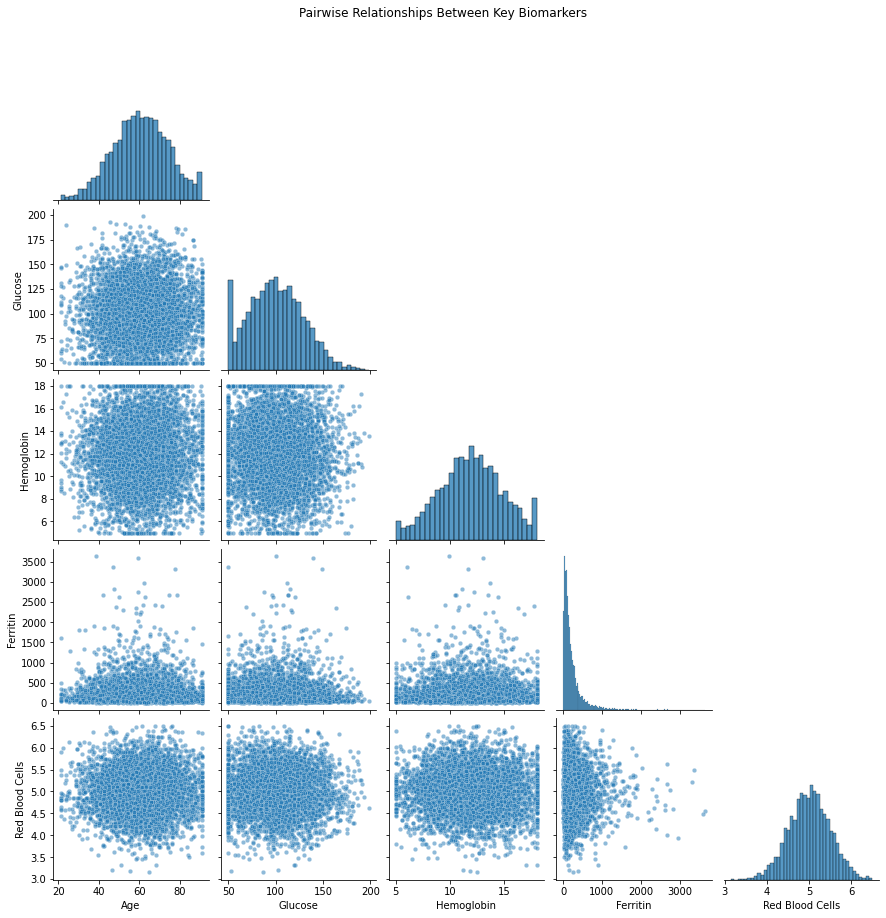

In [67]:
subset_cols = ['Age', 'Glucose', 'Hemoglobin', 'Ferritin', 'Red Blood Cells']
sns.pairplot(df[subset_cols], diag_kind='hist', corner=True, plot_kws={"alpha": 0.5, "s":20})
plt.suptitle("Pairwise Relationships Between Key Biomarkers", y=1.02, fontsize=12)
plt.show()

In [2]:
df = pd.read_csv(f"{path}/synthetic_biomarkers.csv", index_col=0)
df.head()

,Gender,Age,Cortisol,Creatine Kinase (CK),Ferritin,Free Calcium,Glucose,Hemoglobin,Lipase,Monocytes,Red Blood Cells
0,M,61.35,10.28,341.86,118.35,1.25,90.64,15.53,23.13,11.45,5.33
1,F,38.96,2.00,300.33,226.30,1.00,78.12,13.16,30.51,11.72,4.83
2,M,65.40,7.77,1629.04,196.09,1.24,125.74,13.69,0.63,10.79,4.39
3,M,53.31,7.12,144.22,50.94,1.11,66.18,11.83,8.06,13.26,4.76
4,M,67.45,6.67,60.34,233.57,1.30,76.54,9.49,59.33,0.39,5.50


In [8]:
df.describe().T[['min', 'max', 'mean']]

,min,max,mean
Age,21.00,91.00,60.732308
Cortisol,2.00,28.08,9.978096
Creatine Kinase (CK),20.00,7590.69,324.767116
Ferritin,10.00,3642.36,239.720760
Free Calcium,0.85,1.40,1.196686
Glucose,50.00,198.98,100.919200
Hemoglobin,5.00,18.00,11.915046
Lipase,0.63,400.00,43.600038
Monocytes,0.00,21.39,8.003792
Red Blood Cells,3.15,6.50,5.010670
